# Recap of the Challenge details:
- 1. The top 5 most active days of tweet by the subject. 
- 2. The number of tweets and number of retweets. 
- 3. Which 5 people did they retweet their posts the most and how many each. 
- 4. What top 5 hours of the day do they tweet. 
- 5. What kind of device do they use to tweet. 
- 6. On average, how many times do they tweet a day.
- 7. What day did they tweet the most and how many tweets. 
- 8. What month did they tweet the most and how many tweets. 
- 9. What are their top 15 words. 
- 10. What are the top 10 hashtags they used. 

In [1]:
#Import needed libraries
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os, re
from collections import Counter
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud

plt.style.use('ggplot')

In [2]:
#Read in the required file
df = pd.read_csv('Exercise.csv')

# A quick EDA to see what we hold in the dataframe

In [3]:
#Shape of the df
print(f"There are {df.shape[0]:,} rows across {df.shape[1]} columns")

There are 3,229 rows across 13 columns


In [4]:
#the column names are
df.columns

Index(['created_at', 'text', 'in_reply_to_status_id_str', 'source',
       'in_reply_to_screen_name', 'contributors', 'quoted_status_id',
       'quote_count', 'reply_count', 'retweet_count', 'favorite_count',
       'retweeted', 'followers_count'],
      dtype='object')

In [5]:
#Let's see the datat type each column is holding. This will be important info down the line
df.dtypes

created_at                    object
text                          object
in_reply_to_status_id_str    float64
source                        object
in_reply_to_screen_name       object
contributors                 float64
quoted_status_id              object
quote_count                   object
reply_count                   object
retweet_count                  int64
favorite_count                 int64
retweeted                    float64
followers_count              float64
dtype: object

In [6]:
#A peep at other info about our data.
#Observe that some of the columns have null values as they have less than 3,229 non-null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3229 entries, 0 to 3228
Data columns (total 13 columns):
created_at                   3229 non-null object
text                         3229 non-null object
in_reply_to_status_id_str    1023 non-null float64
source                       3229 non-null object
in_reply_to_screen_name      1023 non-null object
contributors                 0 non-null float64
quoted_status_id             3229 non-null object
quote_count                  3229 non-null object
reply_count                  3229 non-null object
retweet_count                3229 non-null int64
favorite_count               3229 non-null int64
retweeted                    0 non-null float64
followers_count              0 non-null float64
dtypes: float64(4), int64(2), object(7)
memory usage: 328.1+ KB


In [7]:
#Finally, a look at the head of our df
df.head()

,created_at,text,in_reply_to_status_id_str,source,in_reply_to_screen_name,contributors,quoted_status_id,quote_count,reply_count,retweet_count,favorite_count,retweeted,followers_count
0,2019-12-19 08:20:07,"On behalf of my family, I wish @bukolasaraki a...",NaN,Twitter for iPhone,NaN,NaN,Not Availabe,Not Availabe,Not Availabe,1227,10787,NaN,NaN
1,2019-12-15 16:08:46,How sweet of my grandchildren to bring me a be...,NaN,Twitter for iPhone,NaN,NaN,Not Availabe,Not Availabe,Not Availabe,943,11928,NaN,NaN
2,2019-12-15 07:53:46,"On behalf of my family, I thank those present ...",NaN,Twitter for iPhone,NaN,NaN,Not Availabe,Not Availabe,Not Availabe,714,6539,NaN,NaN
3,2019-12-13 15:51:58,I congratulate @BorisJohnson on his reelection...,NaN,Twitter for iPhone,NaN,NaN,Not Availabe,Not Availabe,Not Availabe,639,5373,NaN,NaN
4,2019-12-10 09:44:44,#HumanRightsDay means that the global human co...,NaN,Twitter for iPhone,NaN,NaN,Not Availabe,Not Availabe,Not Availabe,822,3380,NaN,NaN


### Que. 1. The top 5 most active days of tweet by the subject. 
- This involves both their tweets and then retweet of other peopele's tweet. So we are looking at all 3,229 tweets

In [8]:
#Notice it is of type object now
df['created_at'].head(1)

0    2019-12-19 08:20:07
Name: created_at, dtype: object

In [9]:
#The type of our date column 'created_at' has to be a time object so we can work with it
#Convert created_at column to datetime
df['created_at'] = pd.to_datetime(df.created_at)

In [10]:
#We now have a datetime object. If any row did not convert we will still be stuck with type 'object'
df['created_at'].head(1)

0   2019-12-19 08:20:07
Name: created_at, dtype: datetime64[ns]

In [11]:
#Let's make new column 'dates' from column 'created_at' to hold only the date like year-month-day
df['dates'] = [line.date() for line in df.created_at] #call date() on each row of datetime value
#Let's have a peek of this column
df.dates.head(2)

0    2019-12-19
1    2019-12-15
Name: dates, dtype: object

In [12]:
#A value count will give us how many times each date occurred which is how many times they tweeted that day
#we save this ina variable 'top5_days'
top5_days = df.dates.value_counts().head()
print(top5_days)

2019-02-03    48
2019-01-30    40
2018-11-19    35
2014-12-03    33
2017-10-07    32
Name: dates, dtype: int64


In [13]:
#We will use similar plot moves so we make a funtion out of it
def plotter(df, col, xlabel, ylabel, title, num):
    """
    args: 
    df= dataframe in question, pandas df
    num = count in head(), int
    col= name of column in focus, str
    xlabel, ylabel, title = xlabel, ylabel and title desired
    
    Create a bar plot from a value count (first ten) on the column specified"""
    
    #Controling figsize to show a wider plot if we have more than 5 items 
    if num < 6:
        a, j = 8, 3
    else:
        a, j = 14, 4
        
    ax = df[col].value_counts().head(num).plot(kind='bar', figsize=(a,j),grid=True, title=title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
    
    #Let's save the plot to file
    ax.get_figure().savefig("plots\\" + title + ".png", bbox_inches="tight")

In [14]:
#House Keeping
#Create a folder for the plots if it does not exist
try:
    os.makedirs('plots')
    print("We just made a 'plots' folder as it didn't exist before")
except:
    print(f"Folder already exists")

Folder already exists


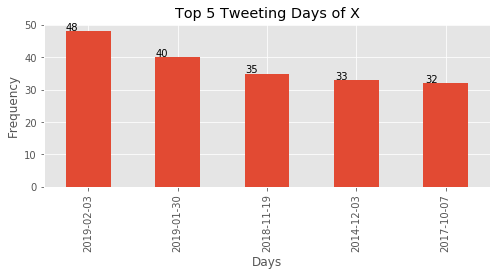

In [15]:
#Let's drop a plot of this info about top tweeting days
plotter(df, 'dates', 'Days', 'Frequency', 'Top 5 Tweeting Days of X', 5)

### Que. 2. The number of tweets and number of retweets.

In [16]:
#To get the this detail we look at the 'text' column as it holds the tweet
#All that start with 'RT' are retwets by the subject otherwise they their original tweet
tweets = [line for line in df.text if not line.startswith('RT')]
retweets = [line for line in df.text if line.startswith('RT')]

#To proof-check, the length of these two should be equal too 3,299 ie total number of tweets
len(retweets) + len(tweets) == len(df)

True

In [17]:
len(df)

3229

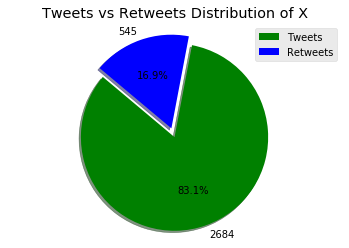

In [18]:
#Data to Plot
len_tweets = len(tweets)
len_retweets = len(retweets)

labels = 'Tweets', 'Retweets'
sizes = [len_tweets, len_retweets]
colors = ['green', 'blue']
explode = (0.1, 0)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels = sizes, autopct='%1.1f%%', colors=colors, shadow=True, startangle=140)

plt.axis('equal')
plt.title("Tweets vs Retweets Distribution of X")
plt.legend(labels)
plt.savefig("plots\\" + 'Tweets vs Retweets Distribution of X' + ".png")
plt.show()

### Que. 3. Which 5 people did they retweet their posts the most and how many each.
- We find these guys from the text column by isolating the retweets and grabbing the first mention

In [19]:
#Working with the list of tweets and retweets above
#Let's eyeball things in both list to be sure we are on track
#First 5 tweets on list
tweets[:5]

['On behalf of my family, I wish @bukolasaraki a very happy birthday. May Allah grant you many more years in good health and continued service to Nigeria. -AA https://t.co/YYHcR3AaSX',
 'How sweet of my grandchildren to bring me a belated birthday cake. #smiles https://t.co/gjak4bGmdt',
 'On behalf of my family, I thank those present and also well-wishers for their prayers at the Wedding Fatiha of my dear son, @HHMustaphaAA and his wife, Afrah El-Nafaty. May Allah bless you all for making it a truly special day for me and my family. -AA https://t.co/a6xniZXW1l',
 'I congratulate @BorisJohnson on his reelection as Prime Minister of the United Kingdom. -AA',
 '#HumanRightsDay means that the global human community abhors dictatorial regimes. To celebrate this day therefore, I again call for the immediate release of all prisoners of good conscience in Nigeria and demand a jettisoning of repressive legislation against free speech - AA.']

In [20]:
#First 5 retweets on list
retweets[:5]

["RT @AUNigeria: HAPPENING NOW: AUN Founder's Day 2019. You are all welcome to this special occasion.\n\nWatch here: https://t.co/W6tXmUQ6oD ht…",
 'RT @omonlakiki: Twenty years ago, Women Trafficking &amp; Child Labour Eradication Foundation (WOTCLEF) was founded by Hajiya Titi Amina Abubak…',
 'RT @omonlakiki: Emmanuel Kwache, veteran journalist &amp; pioneer staff of Atiku Media Office was loyal, resourceful &amp; personable. On behalf of…',
 'RT @PeterObi: It was reassuring that notwithstanding his age and health challenges, Prof Ben Nwabueze (SAN), patriot and foremost constitut…',
 'RT @omonlakiki: No businessman (living or dead) in Africa has worked harder for democracy or contributed more to the progress of higher  ed…']

In [21]:
#Extract the first mention in each retweet
#We're breaking out of the inner loop after first mention instance as we know a line could feature more than 1 mention
retweetees = []
for line in retweets:
    for item in line:
        if item.startswith('@'):
            x = line.split()[1] #split that line of tweet and take the second item, the mention
            x = x.replace(':', '') #it comes with a colon so we replace it with nothing
            retweetees.append(x) #add to our list
            break #So we don't pick up any other one along the line after the first

#Alterantively and shorter, since we know that the retweetee is always the second thing on a line of tweet we can
#just take them out
retweetees2 = [line.split()[1].replace(':', '') for line in retweets] #You gotta love list comprehensions!

In [22]:
#If this went well, we know we should have as many retweetees as there are retweets namely 545.
#Let's check
print(len(retweetees) == len(retweets))
print(len(retweetees2) == len(retweets))
print(retweetees2[:5] == retweetees[:5])

True
True
True


In [23]:
#A look at our retweetees list. First 5
retweetees[:5]

['@AUNigeria', '@omonlakiki', '@omonlakiki', '@PeterObi', '@omonlakiki']

In [24]:
#Let's find the frequency they occur and so the top 5 of them that X retweeted their tweet
freq = Counter(retweetees)

In [25]:
#This is a handful and I hope we get to explain it some day
#What we achieved here is sort the dictionary into a list of tuples pushing the ones with highest occurrnce to the top
sorted_outcome = [(mention, amount) for mention, amount in sorted([(x,y) for y,x in freq.items()], reverse=True)]
#A look at the top 5
sorted_outcome[:5]

[(117, '@AtikuOrg'),
 (31, '@omonlakiki'),
 (25, '@AUNigeria'),
 (24, '@SpokesManAtiku'),
 (14, '@Mustyblax')]

In [26]:
#Let's do this a more friendly way with pandas
#Make an empty dataframe
retweetees_df = pd.DataFrame()
#Create a column with the mentions list
retweetees_df['mentions'] = retweetees
#Get a value count 
retweetees_df.mentions.value_counts().head() #See how it is exact same result like above

@AtikuOrg          117
@omonlakiki         31
@AUNigeria          25
@SpokesManAtiku     24
@Mustyblax          14
Name: mentions, dtype: int64

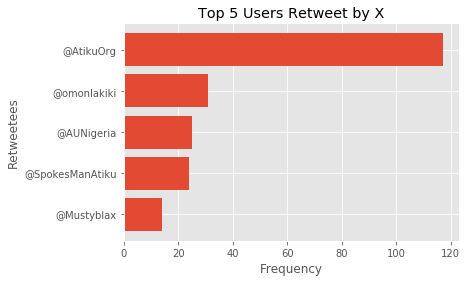

In [27]:
#Plotting with Matplot
mentions = [line[1] for line in sorted_outcome[:5]][::-1]
y_pos = range(len(mentions))
frequnecy = [line[0] for line in sorted_outcome[:5]][::-1]

plt.barh(y_pos, frequnecy, align='center')
plt.yticks(y_pos, mentions)
plt.xlabel('Frequency')
plt.ylabel('Retweetees')
plt.title('Top 5 Users Retweet by X')

plt.show()

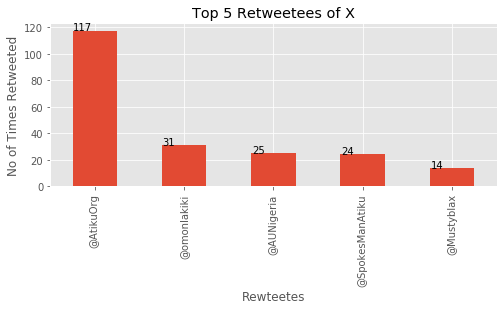

In [28]:
#Let's plot same from the dataframe with top 10
plotter(retweetees_df, 'mentions', 'Rewteetes', 'No of Times Retweeted', 'Top 5 Retweetees of X', 5)

### Que. 4. What top 5 hours of the day do they tweet.

In [29]:
#Let's create another column 'hours' in our original df from created_at. result will be like 00, 01...24 hrs of the day
df['hours'] = [line.time().hour for line in df.created_at]
#A peek
df.hours.head(2)

0     8
1    16
Name: hours, dtype: int64

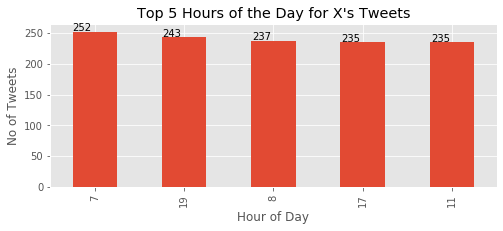

In [30]:
#Lets drop a plot passing the arguments needed
plotter(df, 'hours', 'Hour of Day', 'No of Tweets', "Top 5 Hours of the Day for X's Tweets", 5)

### Que. 5. What kind of device do they use to tweet.

In [31]:
#This info is held on the 'source' column
df.source.head(2)

0    Twitter for iPhone
1    Twitter for iPhone
Name: source, dtype: object

In [32]:
#A frequency count with value counts
df.source.value_counts()

Twitter for iPhone      3097
Twitter Web App           62
Twitter Web Client        61
Medium                     4
Periscope                  3
Facebook                   1
Twitter Media Studio       1
Name: source, dtype: int64

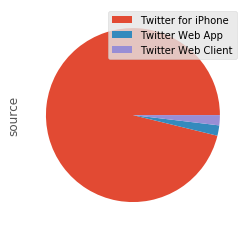

In [33]:
#Let's drop a simple distro plot of the frequency of top 3 items on the list
ax = df.source.value_counts().head(3).plot.pie(labels = None, legend=True)
ax.get_figure().savefig("plots\\" + 'Devices' + ".png")

### Que. 6. On average, how many times do they tweet a day.

In [34]:
#To find the average number of tweets they put out per day we need total days tweeted
#To count the individual number of days, we find the count of value_counts on the days of tweet
total = 0
for item in df.dates.value_counts().items():
    total += 1
print(f"Subject X tweet on {total:,} different days over the period")

Subject X tweet on 1,039 different days over the period


In [35]:
#To get the average, we divide this number by their total number of tweets
print(f"X tweet on the average {len(df)/total:.2f} times a day")

X tweet on the average 3.11 times a day


### Que. 7. What day did they tweet the most and how many tweets.

In [36]:
#From our value_counts on the date field we can get this info
#Iterate and get the first index of the first item being tht top tweet day and the day itselt
for item in df.dates.value_counts().items():
    top_day = item[0].strftime('%B %d, %Y')
    total_tweets = item[1]
    break #we break after first iteration as we are interested just in the first item, the highest.
    
print(f"X tweeted the most on {top_day} with a total of {total_tweets} tweets.")
    
#Alternatiely and shorter (with exact same result)
#Extract the first key from value_counts directly
top_day = df.dates.value_counts().keys()[0].strftime('%B %d, %Y')

#ditto for value
total_tweets = df.dates.value_counts()[0]

print(f"X tweeted the most on {top_day} with a total of {total_tweets} tweets.")

X tweeted the most on February 03, 2019 with a total of 48 tweets.
X tweeted the most on February 03, 2019 with a total of 48 tweets.


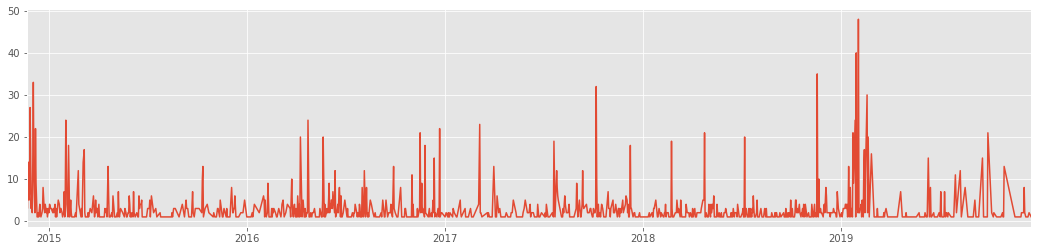

In [37]:
#Our bonus plot can show us the distribution of tweets tweeted over time
df.dates.value_counts().plot(figsize=(18,4))

### Que. 8. What month did they tweet the most and how many tweets.

In [38]:
#We will have a similar operation to the preceeding question
#Let's create a month column from the date column so we can take a value_count of months
df['month'] = [line.strftime('%B') for line in df.dates]

In [39]:
for item in df.month.value_counts().items():
    top_month = item[0]
    total_tweets = item[1]
    break
print(f"Month X tweet the most is {top_month} with at a total of {total_tweets} tweets.")

#For brevity
#Alternatiely and shorter (with exact same result)
#Extract the first key from value_counts directly
top_month = df.month.value_counts().keys()[0]

#ditto for value
total_tweets = df.month.value_counts()[0]
print(f"Month X tweet the most is {top_month} with at a total of {total_tweets} tweets.")

Month X tweet the most is December with at a total of 390 tweets.
Month X tweet the most is December with at a total of 390 tweets.


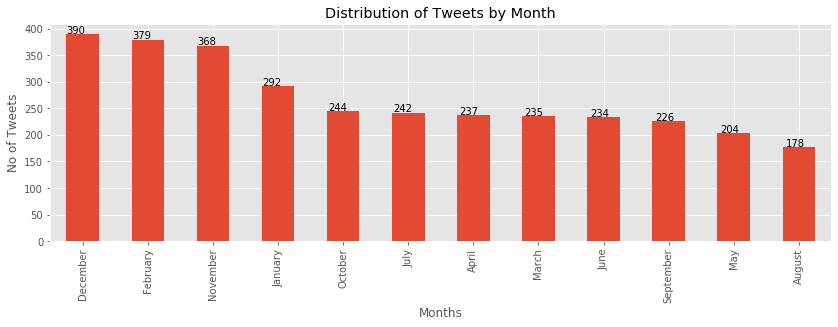

In [40]:
#Bonus plot showing total number of tweets by month in descending order
plotter(df, 'month', 'Months', 'No of Tweets', 'Distribution of Tweets by Month', 12)

In [41]:
#In case you were wondering how to sort this by month
sorted(df.month.value_counts().items(), key=lambda x: datetime.strptime(str(x[0]), "%B"))

[('January', 292),
 ('February', 379),
 ('March', 235),
 ('April', 237),
 ('May', 204),
 ('June', 234),
 ('July', 242),
 ('August', 178),
 ('September', 226),
 ('October', 244),
 ('November', 368),
 ('December', 390)]

### Que. 9. What are their top 15 words.
- Ready for some NLP?

In [42]:
#We will get this from the list of words from the tweet/text column
#Let's make a list of them

words = df.text.tolist()

In [43]:
words[:5]

['On behalf of my family, I wish @bukolasaraki a very happy birthday. May Allah grant you many more years in good health and continued service to Nigeria. -AA https://t.co/YYHcR3AaSX',
 'How sweet of my grandchildren to bring me a belated birthday cake. #smiles https://t.co/gjak4bGmdt',
 'On behalf of my family, I thank those present and also well-wishers for their prayers at the Wedding Fatiha of my dear son, @HHMustaphaAA and his wife, Afrah El-Nafaty. May Allah bless you all for making it a truly special day for me and my family. -AA https://t.co/a6xniZXW1l',
 'I congratulate @BorisJohnson on his reelection as Prime Minister of the United Kingdom. -AA',
 '#HumanRightsDay means that the global human community abhors dictatorial regimes. To celebrate this day therefore, I again call for the immediate release of all prisoners of good conscience in Nigeria and demand a jettisoning of repressive legislation against free speech - AA.']

In [44]:
#Create a set of stopwords from the nltk library of words
stop_words = set(stopwords.words("english"))

#Add AA, which is X's acronymn which occurs a lot but has no value
stop_words.add('aa')

In [45]:
#Let's clean this  and find the top 15 words
##Preprocessing

#Remove escaped word sins and trailing links at end of tweets
corpus = []
for line in words:
    x = line.replace('&amp;', '')
    x = x.split()
#     x = [line for line in x if not line == 'u']
    x = [word for word in x if not word.startswith('http')] #all parts minus lines starting with 'https'
    x = ' '.join(x)
    corpus.append(x)

#Cleaning    
oya = []
for i in range(0, len(corpus)):
    #Remove punctuations
    text = re.sub('[^a-zA-Z]', ' ', corpus[i])
    
    #Convert to lowercase
    text = text.lower()
    
    #remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    
    #remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    ##Convert to list from string
    text = text.split()
    #Remove 'rt'
    text = [line for line in text if not line == 'rt']

    #Lemmatisation
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text if not word in stop_words] 
    text = " ".join(text)
    
    oya.append(text)

In [46]:
oya[2799]

'adebowalalabi atiku given child quality education like banana tree planted stream u imagine wat u done child life'

In [47]:
#Top 15 words with pandas
#Make a list of all words

corpus2 = []

for line in oya:
    x = line.replace(' u ', '') #Remove the last remnants of the ubiquitous you
    x = x.split()
    corpus2.extend(x)
    
#Create empty dataframe
words_f = pd.DataFrame()

words_f['words'] = corpus2
words_f.shape

(41525, 1)

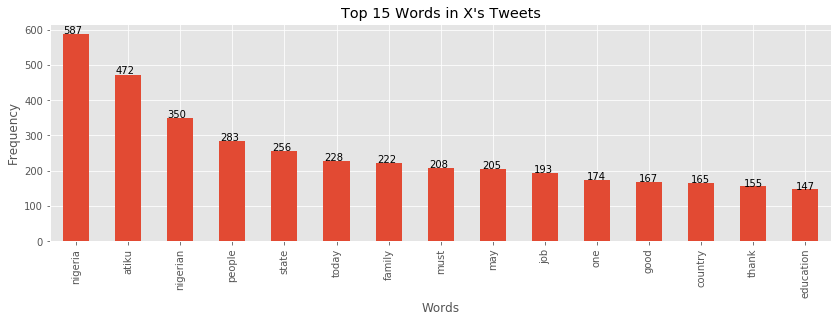

In [48]:
plotter(words_f, 'words', 'Words', 'Frequency', "Top 15 Words in X's Tweets", 15)
# words_f.words.value_counts().head(15).plot.bar(figsize=(14,4))

In [49]:
word_frequency = {}

for line in oya:
    x = line.replace(' u ', '') #Remove the last remnants of the ubiquitous you
    x = line.split()
    for word in x:
        if word in word_frequency.keys():
            word_frequency[word] += 1
        else:
            word_frequency[word] = 1

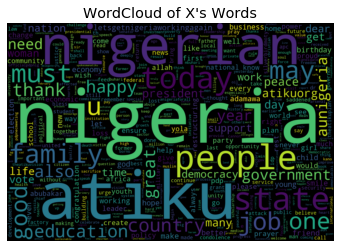

In [50]:
#A wordcloud of X's words
wordcloud = WordCloud(width=1500,height=1000,
                      max_words=500,
                      normalize_plurals=False).generate_from_frequencies(word_frequency)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud of X's Words")
plt.savefig("plots\\" + "WordCloud of X's Words" + ".png")
plt.show()

### Que. 10. What are the top 10 hashtags they used.

In [51]:
#We will get the hash tags from the tweet columns
tweets = df.text.tolist()
hashtags = []
for line in tweets:
    x = line.split() #Make a python list of each line
    for line in x:
        if line.startswith('#'):
            hashtags.append(line)

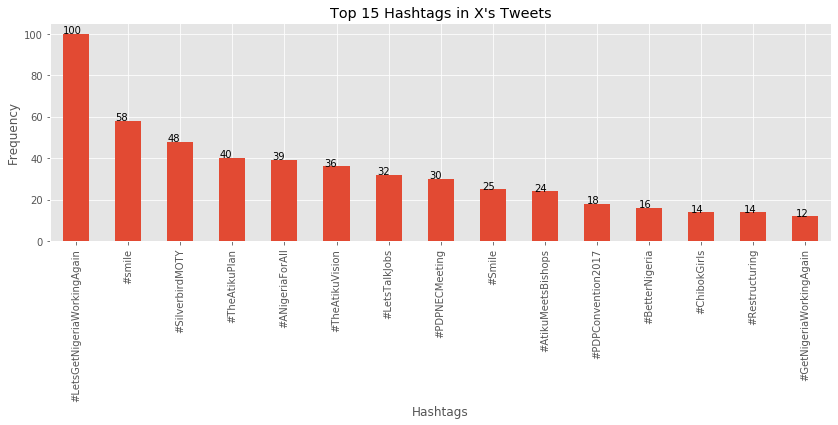

In [52]:
#Let's make a datframe of them and plot
#Create empty dataframe
hashtags_f = pd.DataFrame()

hashtags_f['hashtags'] = hashtags

# hashtags_f.hashtags.value_counts().head(15).plot.bar(figsize=(14,4))
plotter(hashtags_f, 'hashtags', 'Hashtags', 'Frequency', "Top 15 Hashtags in X's Tweets", 15)

In [53]:
#We will do the frequency thing again
hashtag_frequency = {}

for hashtag in hashtags:
    if hashtag in hashtag_frequency.keys():
        hashtag_frequency[hashtag] += 1
    else:
        hashtag_frequency[hashtag] = 1

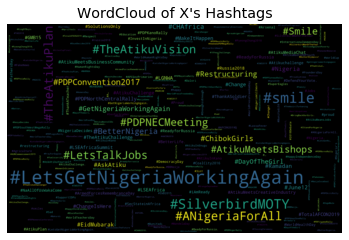

In [54]:
#Wordcloud of X's hashtags
wordcloud = WordCloud(width=1600,height=1000,
                      max_words=300,
                      normalize_plurals=False).generate_from_frequencies(hashtag_frequency)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud of X's Hashtags")
plt.savefig("plots\\" + "WordCloud of X's Hashtags" + ".png")
plt.show()